In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
### Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-a-16-40.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


In [73]:
def load_ibd(out_folder = "/n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/",
             file="av2.tsv", skip_rows=False):
    df = pd.read_csv(out_folder + file, sep="\t")
    if skip_rows:
        df = df[::2]
    return df

def plot_scatter_ibd(ax =0, df_ibds=[], min_cm=12, s=40,
                     c="deepskyblue", m="o", label="", fs=12, 
                     xlim=[-5,3600], ylim=[0,55], savepath="", show=False, 
                     ec="gray", c_col=""):
    """Plot Scatter Plot of IBD.
    c_col: if given plot color stated in column c_col of df_ibds"""
    
    if len(c_col)>0:
        c = df_ibds[c_col].values
        
    if ax==0:
        plt.figure(figsize=(8,8))
        ax = plt.gca()
    
    ### Do the actual Plot
    fig = ax.scatter(df_ibds[f"sum_IBD>{min_cm}"], df_ibds[f"n_IBD>{min_cm}"], s=s,
               ec=ec, linewidth=0.5, color=c, marker=m, label=label)

    ax.set_xlabel(f"Sum IBD >{min_cm}cM [cM]", fontsize=fs)
    ax.set_ylabel(f"# IBD >{min_cm}cM [Count]", fontsize=fs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
        print(f"Saved to {savepath}")
    if show:
        plt.show()
    else:
        return fig

In [3]:
files_gp = ["gp1.tsv", "gp2.tsv", "gp3.tsv"]
files_av = ["av1.tsv", "av2.tsv", "av3.tsv", "av4.tsv", "av5.tsv"]
files_sibs = ["sib.tsv", "hsib.tsv"]
out_folder = "/n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/"

df_gps = [load_ibd(file=f, out_folder=out_folder,
                   skip_rows=True) for f in files_gp]

df_avs = [load_ibd(file=f, out_folder=out_folder) for f in files_av]
df_sibs = load_ibd(file=files_sibs[0], out_folder=out_folder)
df_hsibs = load_ibd(file=files_sibs[1], out_folder=out_folder)

df_par = load_ibd(file="parent.tsv", out_folder=out_folder)[1:2]

In [5]:
len(df_sibs)

100

### 1) Various Single Plots

In [6]:
df_ibds = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.all.v1.tsv", 
                      sep="\t") # compression='gzip'

len(df_ibds)

146117

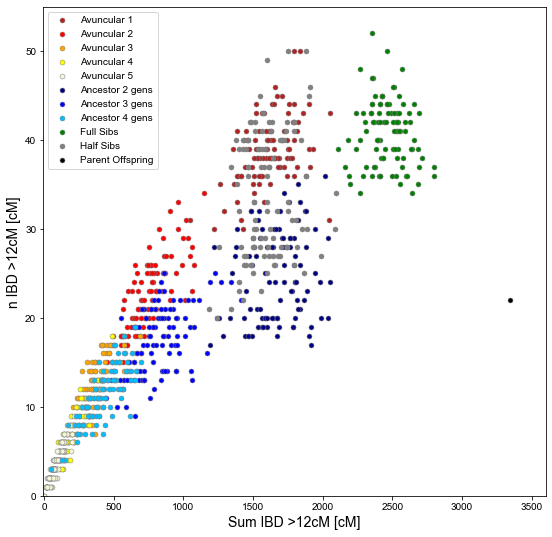

In [5]:
plt.figure(figsize=(9,9))

ax = plt.gca()

plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="firebrick", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="red", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="yellow", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="beige", s=25)

plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2 gens", 
                 c="navy", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3 gens", 
                 c="blue", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4 gens", 
                 c="deepskyblue", s=25)

plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="green", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_hsibs, show=False, label="Half Sibs", 
                 c="gray", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="black", s=25)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)

ax.legend(loc="upper left")
plt.savefig("./figs/pedsim/simulated_pedsim.png", bbox_inches ='tight', pad_inches = 0, dpi=400)
plt.show()

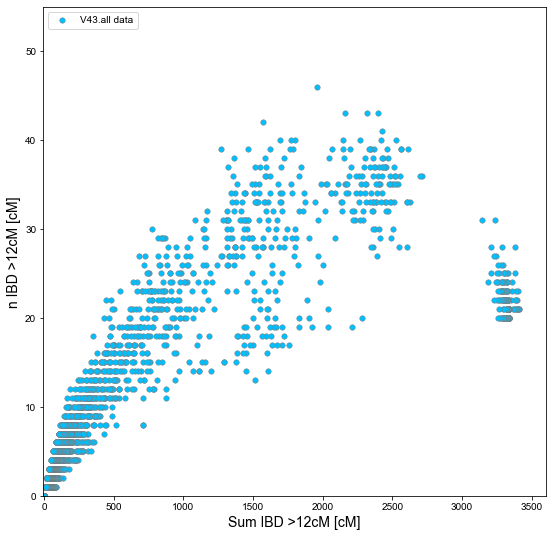

In [6]:
plt.figure(figsize=(9,9))

ax = plt.gca()
plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)
ax.legend(loc="upper left")

plt.savefig("./figs/pedsim/v43.all.png", bbox_inches ='tight', pad_inches = 0, dpi=400)

plt.show()

In [4]:
print("test")

test


### 2) Plot ancIBD European run versus PED_SIM [main figure paper]
Standalone from here

In [72]:
df_meta = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/data/iid_lists/iid_ibd_v54.1b.tsv", sep="\t") #v54.1b is version with >0.7 maxGP
df_ibds = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ind.v54.1c.tsv", sep="\t") # v54.1c is 1000G version
print(f"Loaded {len(df_ibds)} IBD segments")
print(f"IBD data between {len(df_meta)} IIDs")

### Load Pedsim
files_gp = ["gp1.f.tsv", "gp2.f.tsv", "gp3.f.tsv"]
files_av = ["av1.f.tsv", "av2.f.tsv", "av3.f.tsv", "av4.f.tsv", "av5.f.tsv"]
files_sibs = ["sib.f.tsv", "hsib.f.tsv"]
out_folder = "/n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/"

df_gps = [load_ibd(file=f, out_folder=out_folder,
                   skip_rows=True) for f in files_gp]

df_avs = [load_ibd(file=f, out_folder=out_folder) for f in files_av]
df_sibs = load_ibd(file=files_sibs[0], out_folder=out_folder)
df_hsibs = load_ibd(file=files_sibs[1], out_folder=out_folder)

df_par = load_ibd(file="parent.f.tsv", out_folder=out_folder)[1:2]

Loaded 562966 IBD segments
IBD data between 11404 IIDs


In [6]:
df_par

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
1,par100_g2-b1-i1,par100_g3-b1-i1,261.713366,3174.06214,20.0,3174.06214,20.0,3174.06214,20.0,3174.06214,20.0


Saved to ./figs/scatter/ibd.v54.1d.png


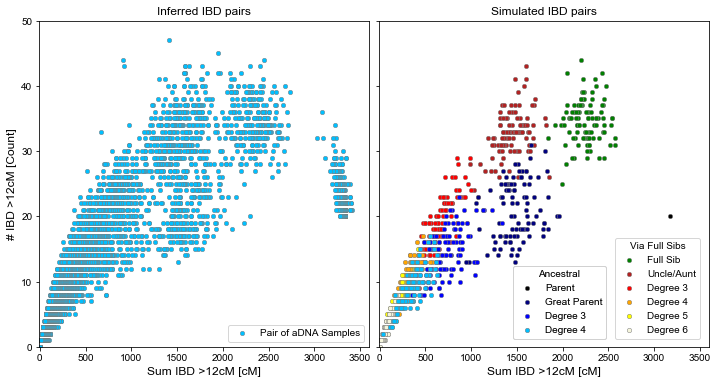

In [11]:
ylim = [0,50]
savepath = "./figs/scatter/ibd.v54.1d.png" #v53.1

fig =plt.figure(figsize=(12,6))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.03)

ax1 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

fs=12
s=20
f1= plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="green", s=s)
f2 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="firebrick", s=s)
f3 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="red", s=s)
f4 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=s)
f5 =plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="yellow", s=s)
f6 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="beige", s=s)

m_anc = "o"
a1 = plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="black", s=s, m=m_anc)
a2 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2", 
                 c="navy", s=s, m=m_anc)
a3 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3", 
                 c="blue", s=s, m=m_anc)
a4 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4", 
                 c="deepskyblue", s=s, m=m_anc)
#plot_scatter_ibd(ax=ax, df_ibds=df_hsibs, show=False, label="Half Sibs", 
#                 c="gray", s=25)

plots = [f1, f2, f3, f4, f5, f6]
lbls = ["Full Sib", "Uncle/Aunt", "Degree 3", "Degree 4", "Degree 5", "Degree 6"]
leg = ax.legend(plots, lbls, fontsize=10, 
                bbox_to_anchor=(0.7, 0.01),
          loc="lower left", title=f"Via Full Sibs")
ax.add_artist(leg)

plots1 = [a1, a2, a3, a4]
lbls1 = ["Parent", "Great Parent", "Degree 3", "Degree 4"]
#assert(n==len(df_p)) # Sanity Check
leg1 = ax.legend(plots1, lbls1, fontsize=10, 
                bbox_to_anchor=(0.39, 0.01),
          loc="lower left", title=f"Ancestral")
ax.add_artist(leg1)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)
ax.set_ylabel("")
ax.set_ylim(ylim)
ax.set_yticklabels([])

### Do the real data
plot_scatter_ibd(ax=ax1, df_ibds=df_ibds, show=False, label=f"Pair of aDNA Samples", s=s)
ax1.legend(loc="lower right")
ax1.set_ylim(ylim) #[0,50] in original


### Titles
ax.set_title("Simulated IBD pairs", fontsize=fs)
ax1.set_title("Inferred IBD pairs", fontsize=fs)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
    
plt.show()

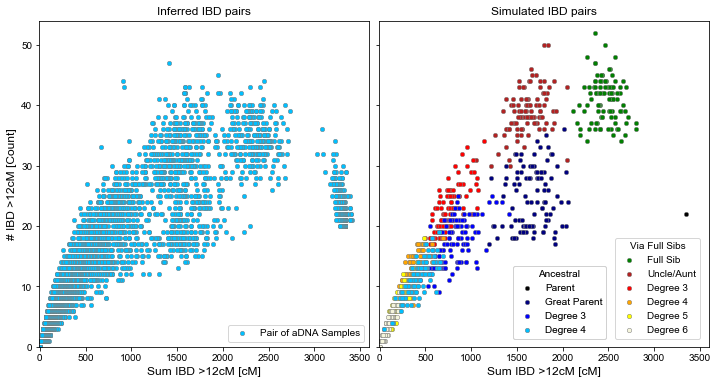

In [27]:
ylim = [0,54]
#savepath = "./figs/scatter/ibd.v54.1c.png" #v53.1
savepath = ""


fig =plt.figure(figsize=(12,6))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.03)

ax1 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

fs=12
s=20
f1= plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="green", s=s)
f2 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="firebrick", s=s)
f3 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="red", s=s)
f4 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=s)
f5 =plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="yellow", s=s)
f6 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="beige", s=s)

m_anc = "o"
a1 = plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="black", s=s, m=m_anc)
a2 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2", 
                 c="navy", s=s, m=m_anc)
a3 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3", 
                 c="blue", s=s, m=m_anc)
a4 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4", 
                 c="deepskyblue", s=s, m=m_anc)
#plot_scatter_ibd(ax=ax, df_ibds=df_hsibs, show=False, label="Half Sibs", 
#                 c="gray", s=25)

plots = [f1, f2, f3, f4, f5, f6]
lbls = ["Full Sib", "Uncle/Aunt", "Degree 3", "Degree 4", "Degree 5", "Degree 6"]
leg = ax.legend(plots, lbls, fontsize=10, 
                bbox_to_anchor=(0.7, 0.01),
          loc="lower left", title=f"Via Full Sibs")
ax.add_artist(leg)

plots1 = [a1, a2, a3, a4]
lbls1 = ["Parent", "Great Parent", "Degree 3", "Degree 4"]
#assert(n==len(df_p)) # Sanity Check
leg1 = ax.legend(plots1, lbls1, fontsize=10, 
                bbox_to_anchor=(0.39, 0.01),
          loc="lower left", title=f"Ancestral")
ax.add_artist(leg1)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)
ax.set_ylabel("")
ax.set_ylim(ylim)
ax.set_yticklabels([])

### Do the real data
plot_scatter_ibd(ax=ax1, df_ibds=df_ibds, show=False, label=f"Pair of aDNA Samples", s=s)
ax1.legend(loc="lower right")
ax1.set_ylim(ylim) #[0,50] in original


### Titles
ax.set_title("Simulated IBD pairs", fontsize=fs)
ax1.set_title("Inferred IBD pairs", fontsize=fs)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
    
plt.show()

### Optional [1x run]: Combine the simulated output to single tsv file

In [11]:
df_sibs["relationship"] = "Full Sib"
df_avs[0]["relationship"] = "Uncle/Aunt"
df_avs[1]["relationship"] = "Via Full Sib Deg. 3"
df_avs[2]["relationship"] = "Via Full Sib Deg. 4"
df_avs[3]["relationship"] = "Via Full Sib Deg. 5"
df_avs[4]["relationship"] = "Via Full Sib Deg. 6"
df_par["relationship"] = "Parent"
df_gps[0]["relationship"] = "Great Parent"
df_gps[1]["relationship"] = "Ancestral Deg. 3"
df_gps[2]["relationship"] = "Ancestral Deg. 4"
df_all = pd.concat([df_sibs, pd.concat(df_avs), df_par, pd.concat(df_gps)])

In [17]:
savepath="./output/pedsim/pedsim_table_allpairs.tsv"
df_all.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df_all)} PEDSIM pairs to: {savepath}")

Saved 901 PEDSIM pairs to: ./output/pedsim/pedsim_table_allpairs.tsv


In [ ]:
[df["relationship"] = for df in df_avs]

## Play around with Inigos data

In [53]:
df = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ind.v54.1c_IO.tsv", 
                 sep="\t", low_memory=False)
df = df.drop(columns="Unnamed: 11")
rel_col = "Relatedness coefficient r (autosomes)"

In [13]:
df.sort_values(by="Relatedness coefficient r (autosomes)", ascending=False)[50:100]

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20,PMR,Number_SNPs,SE_PMR,IIMR_iid1,IIMR_iid2,Relatedness coefficient r (autosomes),Standard error.r,95% CI.r,Comments
155,I34818,I28395,283.861403,3339.637294,20,3339.637294,20,3339.637294,20,3339.637294,20,0.112464,1106856.0,0.000700,0.131793,0.132059,1.147526,0.005306,"[1.137,1.158]",NaN
85,I34819,I28389,283.861403,3339.862993,20,3339.862993,20,3339.862993,20,3339.862993,20,0.112455,1105600.0,0.000684,0.131073,0.130895,1.141460,0.005221,"[1.131,1.152]",NaN
26,I33892,I33891_V53.dupcheck,283.861403,3340.169593,20,3340.169593,20,3340.169593,20,3340.169593,20,0.114949,1031628.0,0.000725,0.132344,0.131631,1.129090,0.005494,"[1.118,1.140]",NaN
37,I31194_V52.dupcheck_d,I31848,283.652203,3340.099093,20,3340.099093,20,3340.099093,20,3340.099093,20,0.115976,1100180.0,0.000706,0.130728,0.130014,1.110412,0.005414,"[1.100,1.121]",NaN
109,S10_S13_noUDG,S10_noUDG.SG,283.700303,3339.761993,20,3339.761993,20,3339.761993,20,3339.761993,20,0.107435,1108107.0,0.000855,0.120255,0.117960,1.097996,0.007179,"[1.084,1.112]",NaN
78,I34645,I34932,283.795903,3339.878893,20,3339.878893,20,3339.878893,20,3339.878893,20,0.121300,1105270.0,0.000729,0.132970,0.134265,1.092187,0.005459,"[1.081,1.103]",NaN
170,I16768,I27865,283.652203,3339.519003,20,3339.519003,20,3339.519003,20,3339.519003,20,0.134605,618483.0,0.000813,0.132906,0.131288,0.981012,0.006155,"[0.969,0.993]",NaN
49,I27793,I25338,283.700303,3340.031104,20,3340.031104,20,3340.031104,20,3340.031104,20,0.129442,810415.0,0.000959,0.127116,0.126560,0.979469,0.007562,"[0.965,0.994]",NaN
535,OBH-52.SG,KD-29.SG,217.670403,3086.183177,36,3086.183177,36,3058.519779,34,3004.175481,31,0.137061,962764.0,0.000798,0.134692,0.133780,0.978959,0.005941,"[0.967,0.991]",NaN
35,I25356,I27811,284.001003,3340.107593,20,3340.107593,20,3340.107593,20,3340.107593,20,0.132308,856589.0,0.000858,0.129222,0.129601,0.977616,0.006633,"[0.965,0.991]",NaN


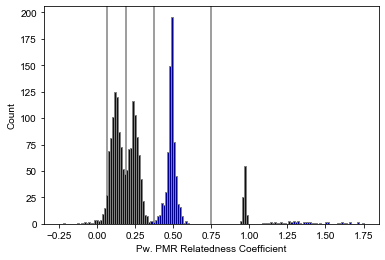

In [87]:
plt.figure()
ax = plt.gca()

ax.axvline(0.75, zorder=0, c="gray")
ax.axvline(0.375, zorder=0, c="gray")
ax.axvline(0.1875, zorder=0, c="gray")
ax.axvline(0.065, zorder=0, c="gray")

ax.hist(df[rel_col], ec="gray", color="darkblue",
        bins = np.linspace(-0.25,1.75, 151))

ax.set_xlabel("Pw. PMR Relatedness Coefficient")
ax.set_ylabel("Count")

plt.savefig("./figs/dumpster/pmr_histogram.pdf", bbox_inches ='tight', pad_inches = 0, dpi=400)

plt.show()

In [50]:
0.75/8

0.09375

### Add color-code

In [58]:
idx = df[rel_col]>0.75
np.sum(idx)

147

In [84]:
cutoffs = [0.065, 0.18375, 0.375, 0.75]
colors = ["#fde725", "#35b779", "#31688e", "#440154"]

df["color_pmr"] = "white"
          
for c,col in zip(cutoffs,colors):
          idx = df[rel_col] >=  c
          print(f'>{c}: n={np.sum(idx)}')
          df.loc[idx, "color_pmr"] = col

>0.065: n=2229
>0.18375: n=1482
>0.375: n=817
>0.75: n=147


In [69]:
len(df)

562966

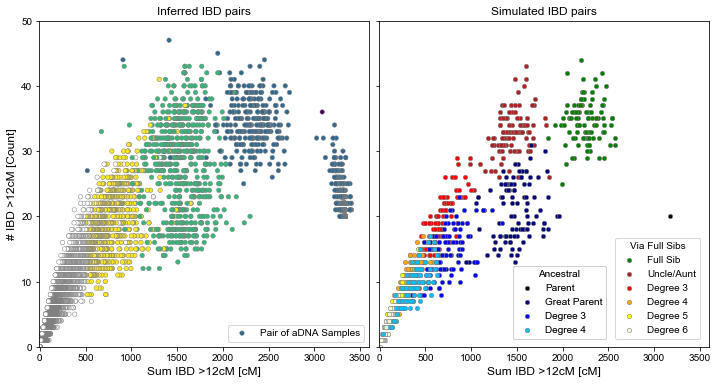

In [85]:
ylim = [0,50]
savepath = "" #./figs/scatter/ibd.v54.1d.png

fig =plt.figure(figsize=(12,6))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.03)

ax1 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

fs=12
s=20
f1= plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="green", s=s)
f2 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="firebrick", s=s)
f3 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="red", s=s)
f4 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=s)
f5 =plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="yellow", s=s)
f6 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="beige", s=s)

m_anc = "o"
a1 = plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="black", s=s, m=m_anc)
a2 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2", 
                 c="navy", s=s, m=m_anc)
a3 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3", 
                 c="blue", s=s, m=m_anc)
a4 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4", 
                 c="deepskyblue", s=s, m=m_anc)
#plot_scatter_ibd(ax=ax, df_ibds=df_hsibs, show=False, label="Half Sibs", 
#                 c="gray", s=25)

plots = [f1, f2, f3, f4, f5, f6]
lbls = ["Full Sib", "Uncle/Aunt", "Degree 3", "Degree 4", "Degree 5", "Degree 6"]
leg = ax.legend(plots, lbls, fontsize=10, 
                bbox_to_anchor=(0.7, 0.01),
          loc="lower left", title=f"Via Full Sibs")
ax.add_artist(leg)

plots1 = [a1, a2, a3, a4]
lbls1 = ["Parent", "Great Parent", "Degree 3", "Degree 4"]
#assert(n==len(df_p)) # Sanity Check
leg1 = ax.legend(plots1, lbls1, fontsize=10, 
                bbox_to_anchor=(0.39, 0.01),
          loc="lower left", title=f"Ancestral")
ax.add_artist(leg1)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)
ax.set_ylabel("")
ax.set_ylim(ylim)
ax.set_yticklabels([])

### Do the real data
plot_scatter_ibd(ax=ax1, df_ibds=df, show=False, 
                 label=f"Pair of aDNA Samples", s=s, c_col="color_pmr")
ax1.legend(loc="lower right")
ax1.set_ylim(ylim) #[0,50] in original


### Titles
ax.set_title("Simulated IBD pairs", fontsize=fs)
ax1.set_title("Inferred IBD pairs", fontsize=fs)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
    
plt.show()

# Area 51

In [70]:
df_ibds = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ind.v54.1c.tsv", sep="\t") # v54.1c is 1000G version

In [ ]:
df_ibds2.sort_values(by="n_IBD>12", ascending=False)[:50]

In [ ]:
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/python3/")  # hack to get development package first in path
from ibd_stats.funcs import new_columns, find_relatives, give_sub_df

In [ ]:
df_sibs

In [83]:
df["color_pmr"]

0         #31688e
1         #31688e
2         #31688e
3         #31688e
4         #31688e
           ...   
562961      white
562962      white
562963      white
562964      white
562965      white
Name: color_pmr, Length: 562966, dtype: object

In [86]:
df[df[c

Index(['iid1', 'iid2', 'max_IBD', 'sum_IBD>8', 'n_IBD>8', 'sum_IBD>12',
       'n_IBD>12', 'sum_IBD>16', 'n_IBD>16', 'sum_IBD>20', 'n_IBD>20', 'PMR',
       'Number_SNPs', 'SE_PMR', 'IIMR_iid1', 'IIMR_iid2',
       'Relatedness coefficient r (autosomes)', 'Standard error.r', '95% CI.r',
       'Comments', 'color_pmr'],
      dtype='object')